In [1]:
import os
import torch.nn as nn
import numpy as np
from random import shuffle
import torch
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader
from tqdm import tqdm
# from preprocess.focal_loss import FocalLoss
# from utils.svdd_loss import SVDDLoss
from dataloader.svdd_dataloader_train import CollisionLoader
from nets.svdd_net import FusionNet
from utils.reconstruction_loss import ReconstructionLoss
%matplotlib inline
torch.manual_seed(42)
np.random.seed(42)

data_path = '/home/iot/audio_visual_collision/Data'
checkpoint_path = '/home/iot/collision_detect/svdd/last_model.pth'
save_path = '/home/iot/collision_detect/output'
workers = 4
batchsize = 64
dropout_rate = 0.3
kernel_num = 32
feature_dim = 512
num_class = 2
use_attention = 0
Epoch = 200
save_name = "svdd_{}_".format(use_attention)
save_dir = os.path.join(save_path, save_name)
os.makedirs(save_dir, exist_ok=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
reconstruction_loss_fn = ReconstructionLoss()
loss_function = nn.MSELoss()


train_data = CollisionLoader(data_path,train=True)
val_data   = CollisionLoader(data_path,train=False)
train_dataloader = DataLoader(train_data, batchsize, shuffle=True, num_workers=workers, drop_last=True)
val_dataloader   = DataLoader(val_data, batchsize, shuffle=True, num_workers=workers, drop_last=True)

random_tensor = torch.load('center.pth').to(device)
print(random_tensor)
model = FusionNet(use_crossattention=use_attention, feature_dim=feature_dim, dropout_rate=dropout_rate, kernel_num=kernel_num, classes=num_class)
model = model.to(device)

if checkpoint_path != '':
    model.load_state_dict(torch.load(checkpoint_path))
    print('Load weights')


cuda
tensor([ 0.2787,  2.8093, -0.3024,  ..., -0.4864, -0.0068, -0.2984],
       device='cuda:0')
Load weights


tensor([2], device='cuda:0')
Reconstruction Loss 0.0289
SVDd Loss for Sample: 0.0040


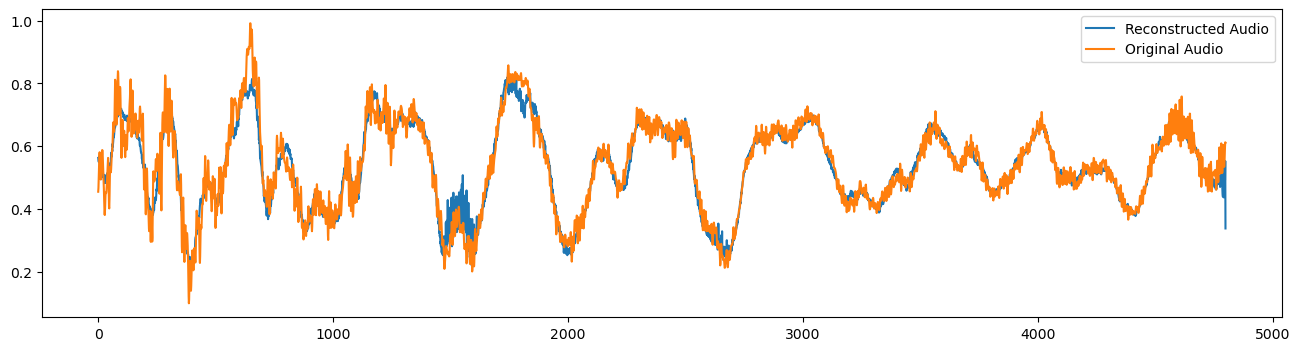

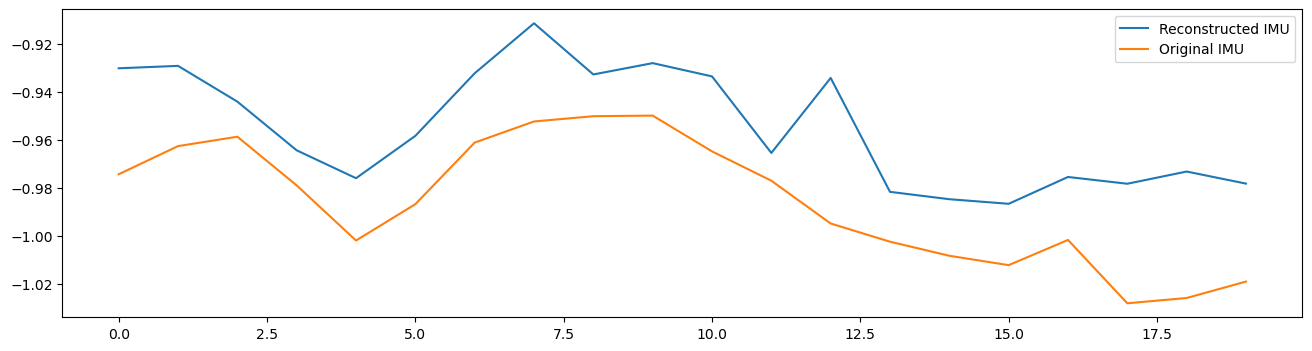

In [18]:
model.eval()
sample_idx = 405
# Change this to the index of the sample you want to load
spec, image, audio, cls = val_data[sample_idx]
spec, image, audio, cls = spec.unsqueeze(0).to(device), image.unsqueeze(0).to(device), audio.unsqueeze(0).to(device), cls.unsqueeze(0).to(device)

anomaly_score, reconstructed_audio, reconstructed_imu = model(audio, image)

reconstruction_loss = reconstruction_loss_fn(image, reconstructed_imu, audio, reconstructed_audio)
target_zero = random_tensor.unsqueeze(0).expand(1, -1)
svdd_loss = loss_function(anomaly_score, target_zero)
total_loss = svdd_loss+reconstruction_loss

print(cls)
print(f"Reconstruction Loss {reconstruction_loss.item():.4f}")
print(f"SVDd Loss for Sample: {svdd_loss.item():.4f}")
plt.figure(figsize=(16, 4))
plt.plot(reconstructed_audio.cpu().detach().numpy().squeeze()[3], label='Reconstructed Audio')
plt.plot(audio.cpu().numpy().squeeze()[3], label='Original Audio')
plt.legend()

plt.figure(figsize=(16, 4))
plt.plot(reconstructed_imu.cpu().detach().numpy().squeeze(), label='Reconstructed IMU')
plt.plot(image.cpu().numpy().squeeze(), label='Original IMU')
plt.legend()


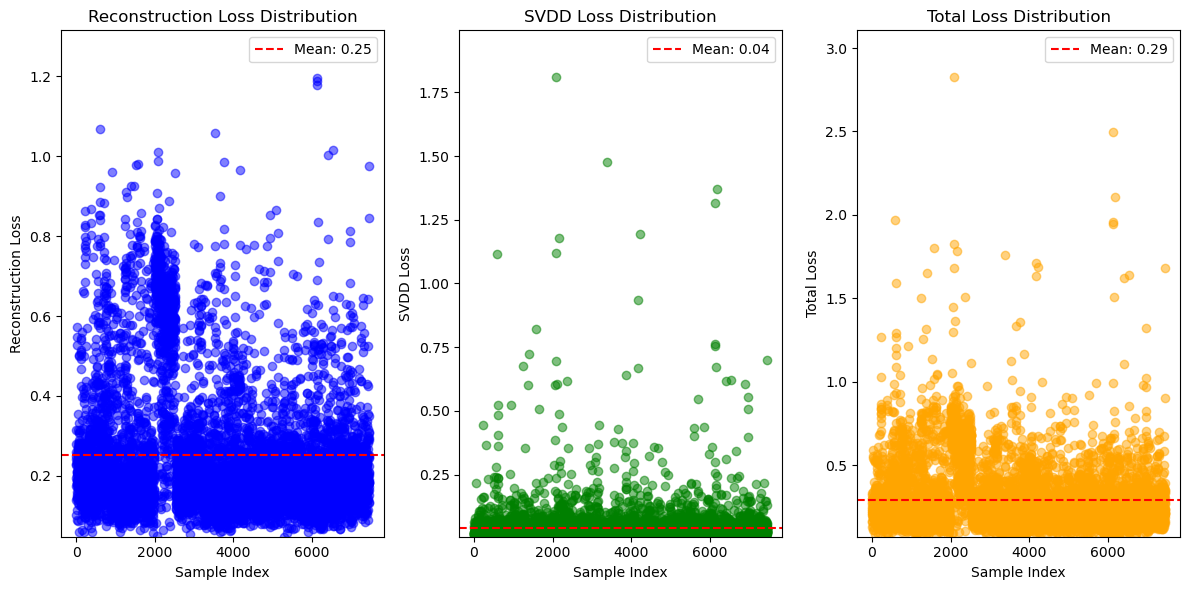

In [11]:
import matplotlib.pyplot as plt

# Initialize lists to store individual loss values
reconstruction_losses = []
svdd_losses = []
total_losses = []

# Iterate over the dataset to collect individual losses
with torch.no_grad():
    for sample_idx in range(len(train_data)):
        spec, image, audio, cls = train_data[sample_idx]
        spec, image, audio, cls = spec.unsqueeze(0).to(device), image.unsqueeze(0).to(device), audio.unsqueeze(0).to(device), cls.unsqueeze(0).to(device)

        # Forward pass through the model
        anomaly_score, reconstructed_audio, reconstructed_imu = model(audio, image)

        # Calculate reconstruction loss for the sample
        reconstruction_loss = reconstruction_loss_fn(image, reconstructed_imu, audio[:,:,:-100], reconstructed_audio[:,:,:-100]) * 10

        # Generate random tensor for SVDD loss
        target_zero = random_tensor.unsqueeze(0).expand(spec.size(0), -1)

        # Calculate SVDD loss for the sample
        svdd_loss = loss_function(anomaly_score, target_zero)*100

        # Calculate total loss for the sample
        total_loss = svdd_loss + reconstruction_loss

        # Append individual loss values to the lists
        reconstruction_losses.append(reconstruction_loss.item())
        svdd_losses.append(svdd_loss.item())
        total_losses.append(total_loss.item())

# Plotting the data distribution of losses using scatter plots
mean_reconstruction_loss = sum(reconstruction_losses) / len(reconstruction_losses)
mean_svdd_loss = sum(svdd_losses) / len(svdd_losses)
mean_total_loss = sum(total_losses) / len(total_losses)

# Plotting the data distribution of losses using scatter plots
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.scatter(range(len(train_data)), reconstruction_losses, color='blue', alpha=0.5)
plt.axhline(y=mean_reconstruction_loss, color='red', linestyle='--', label=f'Mean: {mean_reconstruction_loss:.2f}')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Loss')
plt.title('Reconstruction Loss Distribution')
plt.ylim(min(reconstruction_losses), max(reconstruction_losses)*1.1)
plt.legend()

plt.subplot(1, 3, 2)
plt.scatter(range(len(train_data)), svdd_losses, color='green', alpha=0.5)
plt.axhline(y=mean_svdd_loss, color='red', linestyle='--', label=f'Mean: {mean_svdd_loss:.2f}')
plt.xlabel('Sample Index')
plt.ylabel('SVDD Loss')
plt.title('SVDD Loss Distribution')
plt.ylim(min(svdd_losses), max(svdd_losses)*1.1)
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(range(len(train_data)), total_losses, color='orange', alpha=0.5)
plt.axhline(y=mean_total_loss, color='red', linestyle='--', label=f'Mean: {mean_total_loss:.2f}')
plt.xlabel('Sample Index')
plt.ylabel('Total Loss')
plt.title('Total Loss Distribution')
plt.ylim(min(total_losses), max(total_losses)*1.1)
plt.legend()

plt.tight_layout()
plt.show()

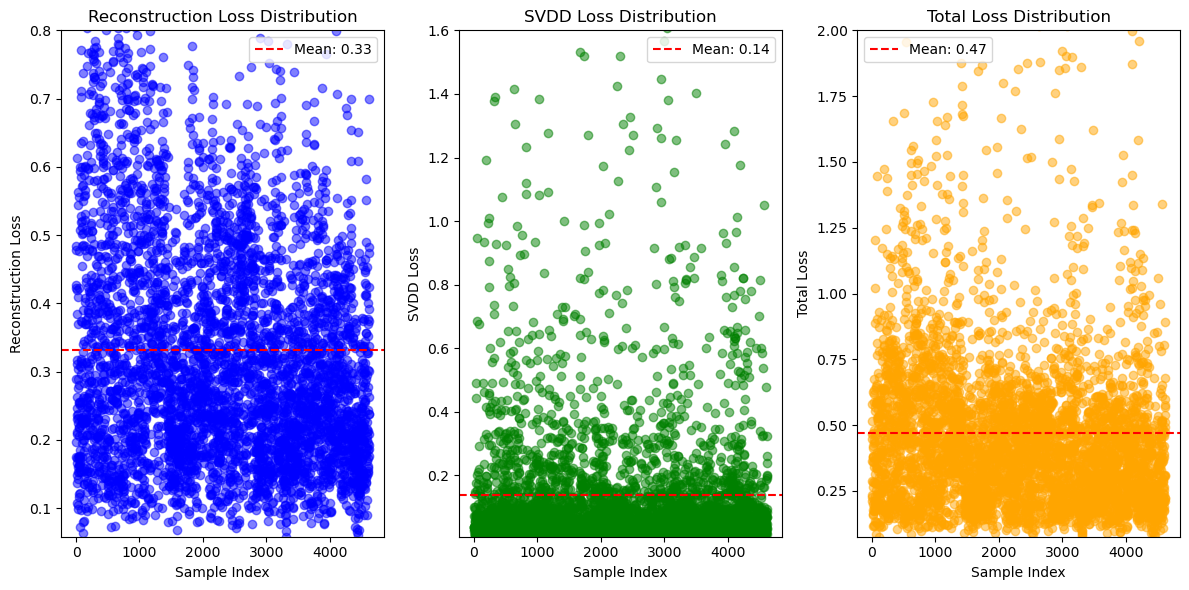

In [12]:
import matplotlib.pyplot as plt

# Initialize lists to store individual loss values
reconstruction_losses = []
svdd_losses = []
total_losses = []
total_sample = 0
# Iterate over the dataset to collect individual losses
with torch.no_grad():
    for sample_idx in range(len(val_data)):
        spec, image, audio, cls = val_data[sample_idx]
        spec, image, audio, cls = spec.unsqueeze(0).to(device), image.unsqueeze(0).to(device), audio.unsqueeze(0).to(device), cls.unsqueeze(0).to(device)
        if cls!=0:
        # Forward pass through the model
            anomaly_score, reconstructed_audio, reconstructed_imu = model(audio, image)
    
            # Calculate reconstruction loss for the sample
            reconstruction_loss = reconstruction_loss_fn(image, reconstructed_imu, audio[:,:,:-100], reconstructed_audio[:,:,:-100]) * 10
    
            # Generate random tensor for SVDD loss
            target_zero = random_tensor.unsqueeze(0).expand(spec.size(0), -1)
    
            # Calculate SVDD loss for the sample
            svdd_loss = loss_function(anomaly_score, target_zero)*100
    
            # Calculate total loss for the sample
            total_loss = svdd_loss + reconstruction_loss
    
            # Append individual loss values to the lists
            reconstruction_losses.append(reconstruction_loss.item())
            svdd_losses.append(svdd_loss.item())
            total_losses.append(total_loss.item())
            total_sample+=1

# Plotting the data distribution of losses using scatter plots
mean_reconstruction_loss = sum(reconstruction_losses) / len(reconstruction_losses)
mean_svdd_loss = sum(svdd_losses) / len(svdd_losses)
mean_total_loss = sum(total_losses) / len(total_losses)

# Plotting the data distribution of losses using scatter plots
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.scatter(range(total_sample), reconstruction_losses, color='blue', alpha=0.5)
plt.axhline(y=mean_reconstruction_loss, color='red', linestyle='--', label=f'Mean: {mean_reconstruction_loss:.2f}')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Loss')
plt.title('Reconstruction Loss Distribution')
plt.ylim(min(reconstruction_losses), 0.8)
plt.legend()

plt.subplot(1, 3, 2)
plt.scatter(range(total_sample), svdd_losses, color='green', alpha=0.5)
plt.axhline(y=mean_svdd_loss, color='red', linestyle='--', label=f'Mean: {mean_svdd_loss:.2f}')
plt.xlabel('Sample Index')
plt.ylabel('SVDD Loss')
plt.title('SVDD Loss Distribution')
plt.ylim(min(svdd_losses), 1.6)
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(range(total_sample), total_losses, color='orange', alpha=0.5)
plt.axhline(y=mean_total_loss, color='red', linestyle='--', label=f'Mean: {mean_total_loss:.2f}')
plt.xlabel('Sample Index')
plt.ylabel('Total Loss')
plt.title('Total Loss Distribution')
plt.ylim(min(total_losses),2)
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
min(reconstruction_losses),min(svdd_losses),min(total_losses)

(0.05803674831986427, 0.0072835469618439674, 0.0760672390460968)

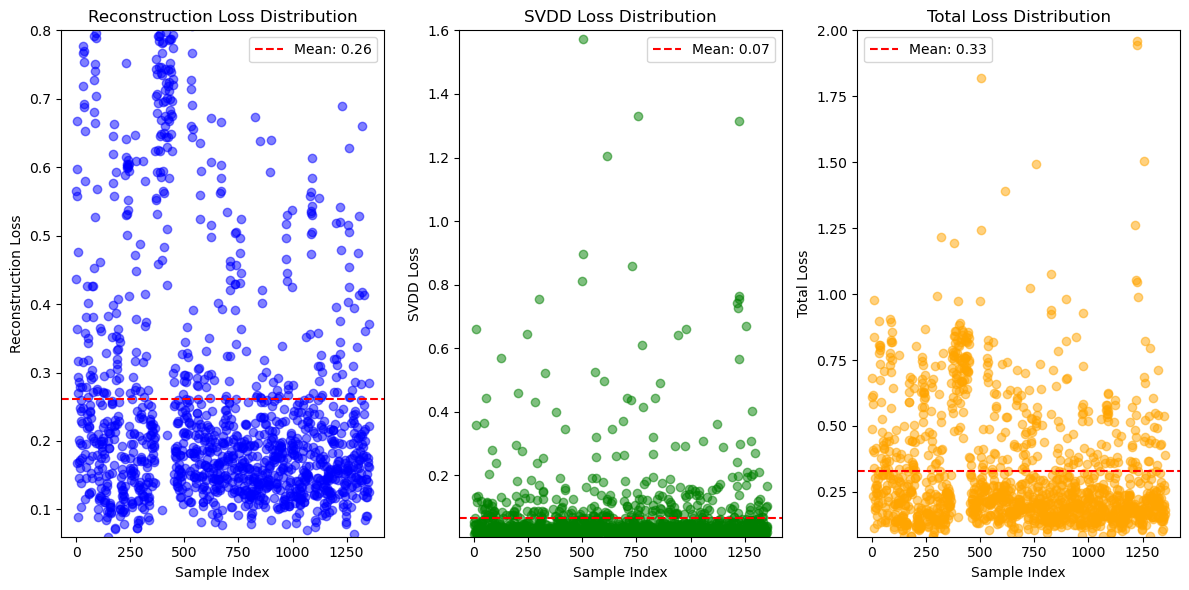

In [14]:
import matplotlib.pyplot as plt

# Initialize lists to store individual loss values
reconstruction_losses = []
svdd_losses = []
total_losses = []
total_sample = 0
# Iterate over the dataset to collect individual losses
with torch.no_grad():
    for sample_idx in range(len(val_data)):
        spec, image, audio, cls = val_data[sample_idx]
        spec, image, audio, cls = spec.unsqueeze(0).to(device), image.unsqueeze(0).to(device), audio.unsqueeze(0).to(device), cls.unsqueeze(0).to(device)
        if cls==0:
        # Forward pass through the model
            anomaly_score, reconstructed_audio, reconstructed_imu = model(audio, image)
    
            # Calculate reconstruction loss for the sample
            reconstruction_loss = reconstruction_loss_fn(image, reconstructed_imu, audio[:,:,:-100], reconstructed_audio[:,:,:-100]) * 10
    
            # Generate random tensor for SVDD loss
            target_zero = random_tensor.unsqueeze(0).expand(spec.size(0), -1)
    
            # Calculate SVDD loss for the sample
            svdd_loss = loss_function(anomaly_score, target_zero)*100
    
            # Calculate total loss for the sample
            total_loss = svdd_loss + reconstruction_loss
    
            # Append individual loss values to the lists
            reconstruction_losses.append(reconstruction_loss.item())
            svdd_losses.append(svdd_loss.item())
            total_losses.append(total_loss.item())
            total_sample+=1

# Plotting the data distribution of losses using scatter plots
mean_reconstruction_loss = sum(reconstruction_losses) / len(reconstruction_losses)
mean_svdd_loss = sum(svdd_losses) / len(svdd_losses)
mean_total_loss = sum(total_losses) / len(total_losses)

# Plotting the data distribution of losses using scatter plots
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.scatter(range(total_sample), reconstruction_losses, color='blue', alpha=0.5)
plt.axhline(y=mean_reconstruction_loss, color='red', linestyle='--', label=f'Mean: {mean_reconstruction_loss:.2f}')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Loss')
plt.title('Reconstruction Loss Distribution')
plt.ylim(min(reconstruction_losses), 0.8)
plt.legend()

plt.subplot(1, 3, 2)
plt.scatter(range(total_sample), svdd_losses, color='green', alpha=0.5)
plt.axhline(y=mean_svdd_loss, color='red', linestyle='--', label=f'Mean: {mean_svdd_loss:.2f}')
plt.xlabel('Sample Index')
plt.ylabel('SVDD Loss')
plt.title('SVDD Loss Distribution')
plt.ylim(min(svdd_losses), 1.6)
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(range(total_sample), total_losses, color='orange', alpha=0.5)
plt.axhline(y=mean_total_loss, color='red', linestyle='--', label=f'Mean: {mean_total_loss:.2f}')
plt.xlabel('Sample Index')
plt.ylabel('Total Loss')
plt.title('Total Loss Distribution')
plt.ylim(min(total_losses),2)
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
from sklearn.metrics import confusion_matrix
import numpy as np
model.eval()
random_tensor = torch.load('center.pth').to(device)
true_labels = []
predicted_labels = []
threshold = 0.45

with torch.no_grad():
    for sample_idx in range(len(val_data)):
        spec, image, audio, cls = val_data[sample_idx]

        spec, image, audio, cls = spec.unsqueeze(0).to(device), image.unsqueeze(0).to(device), audio.unsqueeze(0).to(device), cls.unsqueeze(0).to(device)

        anomaly_score, reconstructed_audio, reconstructed_imu = model(audio, image)

        reconstruction_loss = reconstruction_loss_fn(image, reconstructed_imu, audio, reconstructed_audio) * 10

        target_zero = random_tensor.unsqueeze(0).expand(spec.size(0), -1)

        # Calculate SVDD loss for the sample
        svdd_loss = loss_function(anomaly_score, target_zero)*100

        # Calculate total loss for the sample
        total_loss = svdd_loss + reconstruction_loss

        # Predict class based on total loss
        if total_loss>=0.33 or reconstruction_loss>=0.26 or svdd_loss>=0.07:
            predicted_class=1
        else:
            predicted_class=0

        # Handle ground truth class
        true_class = 1 if cls != 0 else 0

        # Update confusion matrix variables
        true_labels.append(true_class)
        predicted_labels.append(predicted_class)

# Construct confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[ 816  540]
 [1452 3175]]


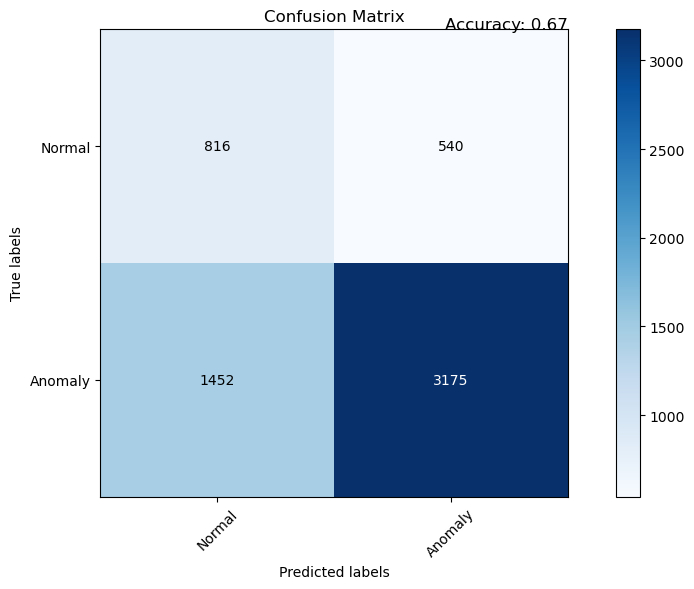

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Define class names
class_names = ['Normal', 'Anomaly']

# Calculate accuracy
accuracy = np.trace(conf_matrix) / float(np.sum(conf_matrix))

# Set the figure size
plt.figure(figsize=(10, 6))

# Plot confusion matrix
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

# Add counts to each cell
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

# Add accuracy to the plot
plt.text(1.5, -0.5, f'Accuracy: {accuracy:.2f}', color='black', fontsize=12, horizontalalignment='right')

# Eliminate grid lines
plt.grid(False)

plt.tight_layout()
plt.show()
